In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

powerfactory_path = r'C:\Program Files\DIgSILENT\PowerFactory 2020 SP4\Python\3.8'
if powerfactory_path not in sys.path:
    sys.path.append(powerfactory_path)
import powerfactory as pf

from pfcommon import *

In [2]:
app = pf.GetApplication()
if app is None:
    raise Exception('Cannot get PowerFactory application')
else:
    print('Successfully obtained PowerFactory application.')

Successfully obtained PowerFactory application.


In [3]:
project_name = '\\Terna_Inerzia\\Nine-bus System'
err = app.ActivateProject(project_name)
if err:
    raise Exception(f'Cannot activate project {project_name}')
print(f'Successfully activated project {project_name}.')

Successfully activated project \Terna_Inerzia\Nine-bus System.


In [4]:
project = app.GetActiveProject()
if project is None:
    raise Exception('Cannot get active project')
print('Successfully obtained active project.')

Successfully obtained active project.


In [5]:
project_folders = {}
for folder_name in ('study',):
    project_folders[folder_name] = app.GetProjectFolder(folder_name)
    if project_folders[folder_name] is None:
        raise Exception(f'No folder "{folder_name}" present')
    print(f'Successfully obtained folder "{folder_name}".')

Successfully obtained folder "study".


## Load flow analysis

In [6]:
study_case_name = '01- Load Flow'
if '.IntCase' not in study_case_name and False:
    study_case_name += '.IntCase'
study_case = project_folders['study'].GetContents(study_case_name)[0]
err = study_case.Activate() # don't know why this returns 1
# if err:
#     raise Exception(f'Cannot activate study case {study_case_name}')
print(f'Successfully activated study case {study_case_name}.')

Successfully activated study case 01- Load Flow.


In [7]:
load_flow = app.GetFromStudyCase('ComLdf')
err = load_flow.Execute()
if err:
    raise Exception(f'Cannot run load flow')
print(f'Successfully run load flow.')

Successfully run load flow.


In [8]:
for bus in app.GetCalcRelevantObjects('*.ElmTerm'):
    voltage = bus.GetAttribute('m:u')
    print(f'{bus.loc_name}: voltage = {voltage:.3f} pu')

Bus 1: voltage = 1.040 pu
Bus 2: voltage = 1.025 pu
Bus 3: voltage = 1.025 pu
Bus 4: voltage = 1.026 pu
Bus 5: voltage = 0.996 pu
Bus 6: voltage = 1.013 pu
Bus 7: voltage = 1.026 pu
Bus 8: voltage = 1.016 pu
Bus 9: voltage = 1.032 pu


## Transient stability analysis

In [9]:
study_case_name = '09- Transient Stability'
if '.IntCase' not in study_case_name:
    study_case_name += '.IntCase'
study_case = project_folders['study'].GetContents(study_case_name)[0]
err = study_case.Activate() # don't know why this returns 1
# if err:
#     raise Exception(f'Cannot activate study case {study_case_name}')
print(f'Successfully activated study case {study_case_name}.')

Successfully activated study case 09- Transient Stability.IntCase.


In [10]:
monitored_variables = {
    '*.ElmSym': ['s:xspeed']
}
# the results of the transient simulation will be stored in this variable
res = app.GetFromStudyCase('*.ElmRes')
for elm_name,var_names in monitored_variables.items():
    for element in app.GetCalcRelevantObjects(elm_name):
        for var_name in var_names:
            res.AddVariable(element, var_name)

In [11]:
line = app.GetCalcRelevantObjects('Line 5-7.ElmLne')[0]
event_folder = app.GetFromStudyCase('IntEvt')
events = {}
for event_name in 'short_circuit', 'clear_short':
    event_folder.CreateObject('EvtShc', event_name)
    evt = event_folder.GetContents(event_name + '.EvtShc')[0]
    if event_name == 'short_circuit':
        evt.p_target = line
        evt.i_shc = 0 # 3-phase short circuit
        evt.time = 1
    elif event_name == 'clear_short':
        evt.p_target = line
        evt.i_shc = 4 # clear short circuit
        evt.time = 1.1
    events[event_name] = evt

In [12]:
inc = app.GetFromStudyCase('ComInc')
inc.iopt_sim = 'rms'
inc.tstart = 0
inc.dtgrd = 1e-3
err = inc.Execute()
if err:
    raise Exception('Cannot compute initial condition')
print('Successfully computed initial condition.')

Successfully computed initial condition.


In [13]:
sim = app.GetFromStudyCase('ComSim')
sim.tstop = 10
err = sim.Execute()
if err:
    raise Exception('Cannot run transient simulation')
print('Successfully run transient simulation.')

Successfully run transient simulation.


In [14]:
res.Load()
for event in events.values():
    event.Delete()

In [15]:
time = get_simulation_time(res)
speed,generators = get_simulation_variables(res, 's:xspeed', elements_name='*.ElmSym', app=app, full_output=True)

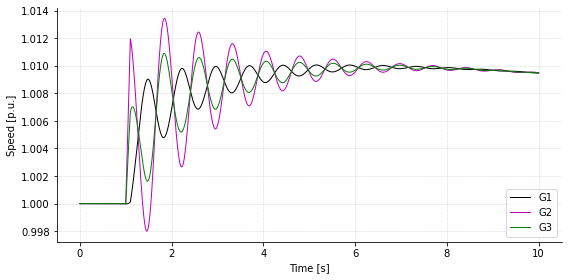

In [16]:
col = 'kmg'
fig,ax = plt.subplots(1, 1, figsize=(8,4))
for i,generator in enumerate(generators):
    ax.plot(time, speed[:,i], col[i], lw=1, label=generator.loc_name)
ax.legend(loc='lower right')
for side in 'right','top':
    ax.spines[side].set_visible(False)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Speed [p.u.]')
ax.grid(which='major', axis='both', lw=0.5, ls=':')
fig.tight_layout()
fig.savefig('Nine-bus_line_fault.pdf')